<a href="https://colab.research.google.com/github/jimmyzhang2003/SParCS/blob/master/COVID_0413_0602_Test_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/

/content/drive/My Drive


In [3]:
import pandas as pd     
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import os
path_to_data = 'MSSM_COVID_FINAL/UPDATED_DATASETS/'
files = []
for file in os.listdir(path_to_data):
  if file.endswith('.txt'):
    files.append(file)

print(files)

##use 0413_TESTED_0602_UPDATE as train data
patient_df = pd.read_csv(path_to_data + files[0], sep="\t", 
                        error_bad_lines=False, encoding='latin1')

#use 0602_TESTED_MINUS0413 as test data
test_df = pd.read_csv(path_to_data + files[1], sep="\t", 
                        error_bad_lines=False, encoding='latin1')

['0413_TESTED_0602_UPDATE.txt', '0602_TESTED_MINUS0413.txt']


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
"There are {} features in the patient dataset.".format(patient_df.shape[1])

'There are 125 features in the patient dataset.'

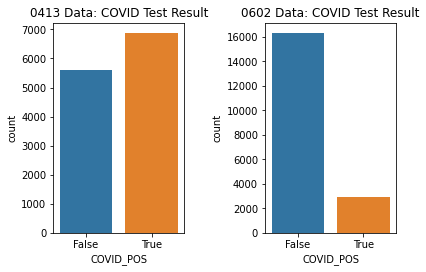

In [6]:
#check distribution of target outcomes in 0413 (train) and 0602 (test) datasets
fig, ax = plt.subplots(1,2)
sns.countplot(patient_df['COVID_POS'], ax = ax[0]).set_title('0413 Data: COVID Test Result')
sns.countplot(test_df['COVID_POS'], ax = ax[1]).set_title('0602 Data: COVID Test Result')
fig.tight_layout(pad = 1.5)
fig.show()

In [7]:
#drop variables irrelevant to COVID test result and any overlapping variables
out_cols = ['NEW_MASKED_MRN', 'NEW_MASKED_ENCOUNTER_EPIC_CSN', 'MASKED_MRN',
       'MASKED_ENCOUNTER_EPIC_CSN', 'ENC_SEQ_NUMBER','MASKED_EXTERNAL_VISIT_ID', 'ENC_ACUITY','COVID_RESULT', 
       'COVID_ORDER_DAYS_SINCE_ENCOUNTER', 'DISCHARGE_DAYS_SINCE_ENCOUNTER', 'PREFERREDLANGUAGE', 'FACILITY',
       'INFECTION_STATUS', 'ENCOUNTER_TYPE', 'ADMISSION_TYPE', 'PATIENT_CLASS', 'LOCATION_OF_CARE', 'DEPARTMENT_NAME',
       'CARE_AREA_TYPE', 'EMERGENCY_DEPARTMENT', 'INPATIENT_NON_ICU', 'ICU', 'DISCHARGE_LOCATON', 'COVID_ORDER',
       'COVID_RESULT_DAYS_SINCE_ENCOUNTER','CANCER_DIAGNOSIS_DESCRIPTION', 'DECEASED_INDICATOR', 
       'DECEASED_DAYS_SINCE_ENCOUNTER', 'TOCILIZUMAB', 'DATE_OF_FIRST_TOCILIZUMAB', 'REMDESIVIR',
       'DATE_OF_FIRST_REMDESIVIR', 'SARILUMAB', 'DATE_OF_FIRST_SARILUMAB','HYDROXYCHLOROQUINE', 
       'DATE_OF_FIRST_HYDROXYCHLOROQUINE','ANAKINRA', 'DATE_OF_FIRST_ANAKINRA', 'AZITHROMYCIN',
       'DATE_OF_FIRST_AZITHROMYCIN', 'INITIAL_AIRWAY_TYPE','INITIAL_AIRWAY_DATE', 'RUN_DATE','ADMITTED', 'COPD_ASTHMA', 
       'INHOSP_DEATH', 'DAYS_TO_INHOSPDEATH_DISCHARGE','ZIPCODE', 'RACE_ETHNICITY_COMBINED']

patient_df_modified = patient_df.copy().drop(columns = out_cols, axis = 1)

#repeat for test set
test_df_modified = test_df.copy().drop(columns = out_cols, axis = 1)

In [8]:
"There are {} features left in the patient dataset.".format(patient_df_modified.shape[1])

'There are 76 features left in the patient dataset.'

In [9]:
#drop columns with >90% missing data
patient_df_modified = patient_df_modified.dropna(thresh = 0.1*patient_df_modified.shape[0], axis = 1)

#repeat for test set
test_df_modified = test_df_modified.dropna(thresh = 0.1*test_df_modified.shape[0], axis = 1)

In [10]:
#label encode SEX variable and rename to MALE
patient_df_modified['SEX'] = patient_df_modified['SEX'].map({'MALE': 1, 'FEMALE':0})
patient_df_modified.rename(columns={'SEX': 'MALE'}, inplace=True)
test_df_modified['SEX'] = test_df_modified['SEX'].map({'MALE': 1, 'FEMALE':0})
test_df_modified.rename(columns={'SEX': 'MALE'}, inplace=True)

In [11]:
#modifying the object values into categorical data 
cols_str = []
for col in patient_df_modified.columns: 
  if patient_df_modified[col].dtype == object:
    cols_str.append(col)

for col in cols_str: 
  patient_df_modified[col] = pd.Categorical(patient_df_modified[col]).codes
  test_df_modified[col] = pd.Categorical(test_df_modified[col]).codes
  patient_df_modified[col] = patient_df_modified[col].replace(-1, np.nan) ##replace -1s with nan
  test_df_modified[col] = test_df_modified[col].replace(-1, np.nan) 
print(cols_str)

['RACE_SIMPLE', 'SMOKING_SIMPLE']


In [12]:
#patient_df_modified = pd.get_dummies(patient_df_modified)
#test_df_modified = pd.get_dummies(test_df_modified)

In [13]:
#target encode categorical variables
#for col in cols_str:  
  #means = patient_df_modified.groupby(col).COVID_POS.mean()
 # patient_df_modified[col] = patient_df_modified[col].map(means)
  #test_df_modified[col] = test_df_modified[col].map(means)

In [14]:
patient_df_modified.head()

,COVID_POS,AGE,MALE,ASTHMA,COPD,HTN,OBSTRUCTIVE_SLEEP_APNEA,OBESITY,DIABETES,CHRONIC_KIDNEY_DISEASE,HIV_FLAG,CANCER_FLAG,CORONARY_ARTERY_DISEASE,ATRIAL_FIBRILLATION,HEART_FAILURE,CHRONIC_VIRAL_HEPATITIS,ALCOHOLIC_NONALCOHOLIC_LIVER_DISEASE,ARDS,ACUTE_KIDNEY_INJURY,ACUTE_VENOUS_THROMBOEMBOLISM,CEREBRAL_INFARCTION,INTRACEREBRAL_HEMORRHAGE,BMI,TEMPERATURE,TEMP_MAX,HEART_RATE,RESPIRATORY_RATE,SYSTOLIC_BP,DIASTOLIC_BP,O2_SAT,O2SAT_MIN,RACE_SIMPLE,SMOKING_SIMPLE,ALBUMIN,ALT,ANC,AST,BASO,BASO_PCT,BUN,CALCIUM,CHLORIDE,CREATININE,CRP,DDIMER,EOS,EOS_PCT,ESR,FERRITIN,HGB,INR,LDH,LYMPHS,LYMPHS_PCT,MONO,MONO_PCT,NEUTRO_PCT,PLT,POTASSIUM,PROCALCITONIN,PT,PTT,SODIUM,TBILI,TROPONIN,WBC,BNP,HCT,IL6
0,False,59,1.0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,96.0,96.0,83.0,NaN,NaN,NaN,97.0,97.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,40,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,98.0,98.6,130.0,20.0,137.0,97.0,100.0,100.0,NaN,NaN,5.0,20.0,2.4,27.0,0.1,1.4,14.0,9.7,102.0,0.82,NaN,NaN,0.0,0.9,NaN,NaN,13.2,NaN,NaN,1.9,40.3,0.3,6.1,51.3,314.0,4.2,NaN,NaN,NaN,NaN,0.5,NaN,4.7,NaN,NaN,NaN
2,False,52,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,25.32,98.1,98.1,91.0,NaN,96.0,63.0,95.0,95.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,False,28,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26.14,98.9,98.9,61.0,16.0,127.0,72.0,99.0,99.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,False,27,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24.28,99.0,99.5,90.0,18.0,112.0,85.0,97.0,97.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,NaN,NaN,13.8,NaN,NaN,NaN,14.2,NaN,6.6,78.7,210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.6,NaN,41.1,NaN


In [15]:
#remove variables that are not present in both datasets
patient_df_modified, test_df_modified = patient_df_modified.align(test_df_modified, join = 'inner', axis =1)

In [16]:
#convert target variable (COVID_POS) values from True/False to 0/1
patient_df_modified['COVID_POS'] *= 1
test_df_modified['COVID_POS'] *= 1

In [17]:
"There are {} features remaining.".format(patient_df_modified.shape[1])

'There are 68 features remaining.'

In [18]:
print('{} NAs in COVID_POS train data'.format(patient_df_modified['COVID_POS'].isnull().sum()))
print('{} NAs in COVID_POS test data'.format(test_df_modified['COVID_POS'].isnull().sum()))

0 NAs in COVID_POS train data
0 NAs in COVID_POS test data


In [19]:
## impute missing values
from sklearn.impute import SimpleImputer

patient_df_modified_imputed = patient_df_modified.copy()
test_df_modified_imputed = test_df_modified.copy()
cat_cols = [col for col in patient_df_modified.columns if patient_df_modified[col].nunique() == 2 and col != 'COVID_POS'] #exclude target variable
num_cols = [col for col in patient_df_modified_imputed.columns if col not in cat_cols and col != 'COVID_POS']

#impute by median for numerical columns
for col in num_cols:
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
  values = patient_df_modified_imputed[col].values.reshape(-1,1)
  transformed_values = imputer.fit_transform(values)
  patient_df_modified_imputed[col] = transformed_values

#impute by most frequent value for categorical columns
for col in cat_cols:
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
  values = patient_df_modified_imputed[col].values.reshape(-1,1)
  transformed_values = imputer.fit_transform(values)
  patient_df_modified_imputed[col] = transformed_values

#repeat for test set
for col in num_cols:
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
  values = test_df_modified_imputed[col].values.reshape(-1,1)
  transformed_values = imputer.fit_transform(values)
  test_df_modified_imputed[col] = transformed_values  

for col in cat_cols:
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
  values = test_df_modified_imputed[col].values.reshape(-1,1)
  transformed_values = imputer.fit_transform(values)
  test_df_modified_imputed[col] = transformed_values

In [20]:
##feature scaling 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#scale train and test data separately 
patient_df_modified_imputed_scaled = pd.DataFrame(data = scaler.fit_transform(patient_df_modified_imputed), columns = patient_df_modified_imputed.columns)
test_df_modified_imputed_scaled = pd.DataFrame(data = scaler.transform(test_df_modified_imputed), columns = test_df_modified_imputed.columns)

In [ ]:
!pip install eli5
!pip install bayesian-optimization

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from  sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectPercentile
from bayes_opt import BayesianOptimization

import eli5
from eli5.sklearn import PermutationImportance
from IPython.core.display import display, HTML

import xgboost as xgb
from xgboost import XGBClassifier
from scipy import sparse, stats

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

class TrainClassifier(BaseEstimator):
    
    def __init__(self, classifier=XGBClassifier(objective ='binary:logistic', tree_hist='gpu_hist')):
        self.classifier = classifier 
    
    def fit(self, X, y=None, **kwargs): 
        self.classifier.fit(X, y)
        return self 

    #randomized search optimization for xgb classifier
    def rs_tune_xgb(self, n_iter, num_folds, X, y):
      folds = StratifiedKFold(n_splits = num_folds, shuffle = False)
      params = {'n_estimators': stats.randint(100, 500),
              'learning_rate': stats.uniform(0.01, 0.4),
              'subsample': stats.uniform(0.2, 1.0),
              'max_depth': stats.randint(1,40),
              'colsample_bytree': stats.uniform(0.2, 1.0),
              'min_child_weight': stats.randint(1,20),
              'gamma': [0.01, 0.1, 0.2 , 0.3, 1, 3, 5, 10],
              }
      optimized_model = RandomizedSearchCV(estimator = self.classifier, 
                                           param_distributions = params,
                                           n_iter = n_iter,
                                           scoring = 'accuracy',
                                           cv = folds,
                                           random_state = np.random.seed(20),
                                           n_jobs = -1,
                                           verbose = 2)
      optimized_model.fit(X, y)
      self.classifier = optimized_model.best_estimator_
      print("Optimal Parameters: {}".format(optimized_model.best_params_))

    #randomized search optimization for RF classifier
    def rs_tune_rf(self, n_iter, num_folds, X, y):
      folds = StratifiedKFold(n_splits = num_folds, shuffle = False)
      params =  {'max_features': ['auto', 'sqrt'],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4],
                 'n_estimators': [int(x) for x in np.linspace(start=100, stop=500, num=20)], 
                 'max_depth': [int(x) for x in np.linspace(start=10, stop=100, num=10)],
                 'bootstrap': [True, False]}
      optimized_model = RandomizedSearchCV(estimator = self.classifier,
                                           param_distributions = params,
                                           n_iter = n_iter,
                                           scoring = 'accuracy',
                                           cv = folds,
                                           random_state = np.random.seed(21),
                                           n_jobs = -1,
                                           verbose = 2)
      optimized_model.fit(X,y)
      self.classifier = optimized_model.best_estimator_
      print("Optimal Parameters: {}".format(optimized_model.best_params_))


    #1st method of feature extraction 
    def permutationImportances(self, model, dataset, X, y=None, display=False):
      model = model.fit(X, y)
      perm = PermutationImportance(model, random_state=99).fit(X, y)
      perm_df = eli5.format_as_dataframe(eli5.explain_weights(perm, feature_names=X.columns.tolist()))
      if display: 
        display(eli5.show_weights(perm, feature_names=X.columns.tolist(), top=20))
      perm_df_filtered = perm_df[perm_df['weight'] >= 0]
      dataset_filtered = dataset[list(perm_df_filtered['feature'])]
      return dataset_filtered

    #2nd method of feature extraction
    def rfcImportancesPlot(self, data, model): 
      important_features = data.columns
      importances = model.feature_importances_
      idx = np.argsort(importances)

      plt.figure(figsize=(20, 20))
      plt.title('Random Forests Feature Importances')
      x, y = range(len(idx)), importances[idx]
      plt.barh(x, y, color='b', align='center')
      plt.yticks(x, [important_features[i] for i in idx])
      plt.show()
    
    def rfcSelectPercentile(self, model, X_train, X_test, y_train, y_test, display=True):
      sfm = SelectPercentile(percentile=10)
      sfm.fit_transform(X_train, y_train)

      columns = np.asarray(X_train.columns.values)
      support = np.asarray(sfm.get_support())
      cols_with_support = columns[support]
      X_train_transformed = pd.DataFrame(sfm.transform(X_train), columns=cols_with_support)
      X_test_transformed = pd.DataFrame(sfm.transform(X_test), columns =cols_with_support)

      if display:
        self.rfcImportancesPlot(X_train, model)
      return X_train_transformed, X_test_transformed 

    #3rd method of feature extraction 
    def varianceThresholding(self, dataset, X_train, X_test):
        variance = dataset.var()
        avg_variance = np.average(variance)
        v_thresh = VarianceThreshold(threshold=avg_variance)
        v_thresh.fit(X_train)
        return X_train[X_train.columns[v_thresh.get_support(indices = True)]], X_test[X_test.columns[v_thresh.get_support(indices = True)]]

    #4th method of feature extraction 
    def highCorrelation(self, dataset):
      correlation_matrix = dataset.corr().abs()
      upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool8)
      select_ut = correlation_matrix.where(upper_triangle)
      hc = [col for col in dataset.columns if any(select_ut[col] > 0.95)]
      dataset = dataset.drop(columns = hc, axis=1)
      return dataset 
    
    def predict(self, X, y=None):
        self.classifier.predict(X)

    def score(self, X, y):
        testing_predictions = self.classifier.predict(X)
        predictions = [round(value) for value in testing_predictions]
        accuracy = accuracy_score(y, predictions)
        return ("Accuracy: %.2f%%" % (accuracy * 100.0))

    def auc_score(self, X, y):
        testing_predictions = self.classifier.predict(X)
        predictions = [round(value) for value in testing_predictions]
        auc = roc_auc_score(y, predictions)
        return ("AUC: %.4f" % (auc))
    
    def cross_val_acc(self, X, y):
        scores = cross_val_score(self.classifier, X, y, cv=5, scoring = 'accuracy')
        return ('CV Accuracy: %.2f%%' % (scores.mean() *100.0))

    def class_report(self, X, y):
        testing_predictions = self.classifier.predict(X)
        predictions = [round(value) for value in testing_predictions]
        return classification_report(y, predictions)

    def full_report(self, X_train, y_train, X_test, y_test):
        print('Train', self.score(X_train, y_train))
        print(self.cross_val_acc(X_train, y_train))
        print('Test', self.score(X_test, y_test))
        print('Train', self.auc_score(X_train, y_train))
        print('Test', self.auc_score(X_test, y_test))
        print(self.class_report(X_test, y_test))
    
    def displayPredictionMatrix(self, X_test, y_test):
      unique_labels = [0, 1]
      testing_predictions = self.classifier.predict(X_test)
      seed = np.random.seed(0)
      matrix = confusion_matrix(y_test, testing_predictions, labels=unique_labels)
      sns.heatmap(matrix, annot=True, xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
      plt.ylabel('Actual/True Label')
      plt.xlabel('Predicted Label')
      plt.title('Confusion Matrix for Predicted Labeling')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [23]:
features = [feature for feature in patient_df_modified_imputed_scaled.columns if feature != "COVID_POS"]

X_train = patient_df_modified_imputed_scaled[features]
y_train = patient_df_modified_imputed_scaled['COVID_POS']

In [24]:
import pickle

pipe = Pipeline([('preprocessing', MinMaxScaler()),  
                 ('classifier', RandomForestClassifier())])
               
params =  {'classifier': [RandomForestClassifier()], 
         'preprocessing': [MinMaxScaler(feature_range=(0, 1))],
         'classifier__max_features': ['auto', 'sqrt'],
         'classifier__min_samples_split': [2, 5, 10],
         'classifier__min_samples_leaf': [1, 2, 4],
         'classifier__n_estimators': [int(x) for x in np.linspace(start=100, stop=500, num=20)], 
         'classifier__max_depth': [int(x) for x in np.linspace(start=10, stop=100, num=10)],
         'classifier__bootstrap': [True, False]}

rscv = RandomizedSearchCV(pipe, params, n_iter=60, verbose=2, cv=5, random_state=np.random.seed(1), n_jobs=-1, scoring = 'accuracy')
rscv.fit(X_train, y_train)
random_forest_best = rscv.best_params_['classifier']
filename = 'random_forest_best.sav'
rfcb_saved = pickle.dump(random_forest_best, open(filename, 'wb'))
rfcb_loaded = pickle.load(open(filename, 'rb'))
rfcb_model = rfcb_loaded.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 28.8min finished


In [25]:
#use preprocessed 0413 dataset as train and preprocessed 0602 dataset as test
X_train = patient_df_modified_imputed_scaled[features]
y_train = patient_df_modified_imputed_scaled['COVID_POS']
X_test = test_df_modified_imputed_scaled[features]
y_test = test_df_modified_imputed_scaled['COVID_POS']

In [26]:
# baseline XGB model (without feature selection or optimization)
tr = TrainClassifier()
tr.fit(X_train, y_train)
tr.full_report(X_train, y_train, X_test, y_test)

Train Accuracy: 77.00%
CV Accuracy: 74.68%
Test Accuracy: 81.66%
Train AUC: 0.7782
Test AUC: 0.6955
              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89     16323
         1.0       0.42      0.52      0.46      2940

    accuracy                           0.82     19263
   macro avg       0.66      0.70      0.68     19263
weighted avg       0.83      0.82      0.82     19263



In [27]:
# baseline RFC model 
tr_rfc = TrainClassifier(classifier=RandomForestClassifier())
tr_rfc.fit(X_train, y_train)
tr_rfc.full_report(X_train, y_train, X_test, y_test)

Train Accuracy: 97.56%
CV Accuracy: 73.16%
Test Accuracy: 82.72%
Train AUC: 0.9761
Test AUC: 0.7012
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90     16323
         1.0       0.44      0.52      0.48      2940

    accuracy                           0.83     19263
   macro avg       0.68      0.70      0.69     19263
weighted avg       0.84      0.83      0.83     19263



In [28]:
# XGB with permutation importances and randomized search optimization
tr_perm = TrainClassifier()
permutation_dataset = tr_perm.permutationImportances(rfcb_model, patient_df_modified_imputed_scaled, X_train, y_train, display)
X_train_perm = permutation_dataset
X_test_perm = test_df_modified_imputed[permutation_dataset.columns]

Weight,Feature
0.0685 ± 0.0018,AGE
0.0557 ± 0.0016,TEMPERATURE
0.0487 ± 0.0020,TEMP_MAX
0.0465 ± 0.0020,BMI
0.0435 ± 0.0021,HEART_RATE
0.0411 ± 0.0034,CALCIUM
0.0352 ± 0.0025,WBC
0.0312 ± 0.0033,O2SAT_MIN
0.0231 ± 0.0012,RACE_SIMPLE
0.0228 ± 0.0019,O2_SAT


In [29]:
tr_perm.rs_tune_xgb(n_iter = 60, num_folds = 5, X = X_train_perm, y = y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.1min finished


Optimal Parameters: {'colsample_bytree': 0.6410759401431649, 'gamma': 5, 'learning_rate': 0.05885226704669288, 'max_depth': 7, 'min_child_weight': 19, 'n_estimators': 303, 'subsample': 0.7378840636118942}


In [31]:
tr_perm.fit(X_train_perm, y_train)
tr_perm.full_report(X_train_perm, y_train, X_test_perm, y_test)

Train Accuracy: 79.25%
CV Accuracy: 74.90%
Test Accuracy: 83.82%
Train AUC: 0.7971
Test AUC: 0.5365
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     16323
         1.0       0.39      0.10      0.16      2940

    accuracy                           0.84     19263
   macro avg       0.62      0.54      0.54     19263
weighted avg       0.79      0.84      0.80     19263



In [32]:
# RFC with permutation importances
tr_perm_rfc = TrainClassifier(classifier=RandomForestClassifier())

tr_perm_rfc.rs_tune_rf(n_iter = 60, num_folds = 5, X = X_train_perm, y = y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 23.2min finished


Optimal Parameters: {'n_estimators': 205, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}


In [33]:
tr_perm_rfc.fit(X_train_perm, y_train)
tr_perm_rfc.full_report(X_train_perm, y_train, X_test_perm, y_test)

Train Accuracy: 89.03%
CV Accuracy: 74.46%
Test Accuracy: 81.87%
Train AUC: 0.8939
Test AUC: 0.4990
              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90     16323
         1.0       0.15      0.04      0.06      2940

    accuracy                           0.82     19263
   macro avg       0.50      0.50      0.48     19263
weighted avg       0.74      0.82      0.77     19263



In [36]:
#variance thresholding XGB
tr_vt = TrainClassifier()
X_train_vt, X_test_vt = tr_vt.varianceThresholding(patient_df_modified_imputed_scaled, X_train, X_test)
tr_vt.fit(X_train_vt, y_train)
tr_vt.full_report(X_train_vt, y_train, X_test_vt, y_test)

Train Accuracy: 67.31%
CV Accuracy: 65.87%
Test Accuracy: 56.84%
Train AUC: 0.6665
Test AUC: 0.6272
              precision    recall  f1-score   support

         0.0       0.91      0.54      0.68     16323
         1.0       0.22      0.71      0.33      2940

    accuracy                           0.57     19263
   macro avg       0.57      0.63      0.51     19263
weighted avg       0.81      0.57      0.63     19263



In [37]:
# VT RFC
tr_vt_rfc = TrainClassifier(classifier=RandomForestClassifier())
tr_vt_rfc.fit(X_train_vt, y_train)
tr_vt_rfc.full_report(X_train_vt, y_train, X_test_vt, y_test)

Train Accuracy: 80.90%
CV Accuracy: 62.34%
Test Accuracy: 55.29%
Train AUC: 0.8078
Test AUC: 0.5907
              precision    recall  f1-score   support

         0.0       0.89      0.54      0.67     16323
         1.0       0.20      0.65      0.31      2940

    accuracy                           0.55     19263
   macro avg       0.55      0.59      0.49     19263
weighted avg       0.79      0.55      0.61     19263



In [39]:
#select percentile feature selection XGB
tr_pctl = TrainClassifier()
tr_pctl.fit(X_train, y_train)
X_train_transformed, X_test_transformed = tr_pctl.rfcSelectPercentile(rfcb_model, X_train, X_test, y_train, y_test, display=False)

In [42]:
tr_pctl.rs_tune_xgb(n_iter = 60, num_folds = 5, X = X_train_transformed, y = y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 297 out of 300 | elapsed:  7.9min remaining:    4.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.9min finished


Optimal Parameters: {'colsample_bytree': 0.6410759401431649, 'gamma': 5, 'learning_rate': 0.05885226704669288, 'max_depth': 7, 'min_child_weight': 19, 'n_estimators': 303, 'subsample': 0.7378840636118942}


In [43]:
tr_pctl.fit(X_train_transformed, y_train)

tr_pctl.full_report(X_train_transformed, y_train, X_test_transformed, y_test)

print('Selected Features:', X_train_transformed.columns)

Train Accuracy: 72.54%
CV Accuracy: 70.60%
Test Accuracy: 79.15%
Train AUC: 0.7297
Test AUC: 0.6759
              precision    recall  f1-score   support

         0.0       0.91      0.84      0.87     16323
         1.0       0.37      0.51      0.43      2940

    accuracy                           0.79     19263
   macro avg       0.64      0.68      0.65     19263
weighted avg       0.82      0.79      0.80     19263

Selected Features: Index(['AGE', 'TEMPERATURE', 'TEMP_MAX', 'RESPIRATORY_RATE', 'O2_SAT',
       'O2SAT_MIN', 'CALCIUM'],
      dtype='object')


In [45]:
# select percentile RF model
tr_pctl_rfc = TrainClassifier(classifier=RandomForestClassifier())

tr_pctl_rfc.rs_tune_rf(n_iter = 60, num_folds = 5, X = X_train_transformed, y = y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.9min finished


Optimal Parameters: {'n_estimators': 268, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}


In [47]:
tr_pctl_rfc.fit(X_train_transformed, y_train)

tr_pctl_rfc.full_report(X_train_transformed, y_train, X_test_transformed, y_test)

Train Accuracy: 75.80%
CV Accuracy: 70.76%
Test Accuracy: 79.39%
Train AUC: 0.7646
Test AUC: 0.6755
              precision    recall  f1-score   support

         0.0       0.90      0.85      0.87     16323
         1.0       0.37      0.51      0.43      2940

    accuracy                           0.79     19263
   macro avg       0.64      0.68      0.65     19263
weighted avg       0.82      0.79      0.81     19263



In [ ]:
#first simple XGB model with select vars 
tr_simple1 = TrainClassifier()

X_train_simple1 = X_train[['AGE', 'MALE','RACE_SIMPLE', 'ASTHMA', 'COPD', 'HTN', 'OBSTRUCTIVE_SLEEP_APNEA', 
                          'OBESITY', 'DIABETES', 'CHRONIC_KIDNEY_DISEASE', 'HIV_FLAG', 'CANCER_FLAG', 'CORONARY_ARTERY_DISEASE', 
                          'ATRIAL_FIBRILLATION', 'HEART_FAILURE', 'CHRONIC_VIRAL_HEPATITIS', 'ALCOHOLIC_NONALCOHOLIC_LIVER_DISEASE', 
                          'SMOKING_SIMPLE', 'BMI','O2_SAT', 'TEMPERATURE']]
X_test_simple1 = X_test[X_train_simple1.columns]

tr_simple1.rs_tune_xgb(n_iter = 60, num_folds=5, X = X_train_simple1, y = y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.1min finished


Optimal Parameters: {'colsample_bytree': 0.7822411232852156, 'gamma': 10, 'learning_rate': 0.12813400566021746, 'max_depth': 11, 'min_child_weight': 11, 'n_estimators': 313, 'subsample': 0.934300519317053}


In [ ]:
tr_simple1.fit(X_train_simple1, y_train)
tr_simple1.full_report(X_train_simple1, y_train, X_test_simple1, y_test)

Train Accuracy: 71.72%
CV Accuracy: 69.56%
Test Accuracy: 71.84%
Train AUC: 0.7166
Test AUC: 0.6567
              precision    recall  f1-score   support

         0.0       0.91      0.75      0.82     16323
         1.0       0.29      0.57      0.38      2940

    accuracy                           0.72     19263
   macro avg       0.60      0.66      0.60     19263
weighted avg       0.81      0.72      0.75     19263



In [ ]:
#first simple RF model
tr_simple1_rfc = TrainClassifier(classifier=RandomForestClassifier())

tr_simple1_rfc.rs_tune_rf(n_iter = 60, num_folds = 5, X = X_train_simple1, y = y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.7min finished


Optimal Parameters: {'n_estimators': 394, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': False}


In [ ]:
tr_simple1_rfc.fit(X_train_simple1, y_train)
tr_simple1_rfc.full_report(X_train_simple1, y_train, X_test_simple1, y_test)

Train Accuracy: 82.37%
CV Accuracy: 69.24%
Test Accuracy: 69.98%
Train AUC: 0.8254
Test AUC: 0.6530
              precision    recall  f1-score   support

         0.0       0.91      0.72      0.80     16323
         1.0       0.27      0.59      0.37      2940

    accuracy                           0.70     19263
   macro avg       0.59      0.65      0.59     19263
weighted avg       0.81      0.70      0.74     19263



In [ ]:
#add easily obtained lab values
#second simple XGB model
tr_simple2 = TrainClassifier()

simple2_cols = list(X_train_simple1.columns) + ['HGB', 'WBC', 'PLT', 'SODIUM', 'POTASSIUM', 'CHLORIDE', 'BUN', 'CREATININE']
X_train_simple2 = X_train[simple2_cols]
X_test_simple2 = X_test[X_train_simple2.columns]

tr_simple2.rs_tune_xgb(n_iter = 60, num_folds=5, X = X_train_simple2, y = y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 19.1min finished


Optimal Parameters: {'colsample_bytree': 0.6410759401431649, 'gamma': 5, 'learning_rate': 0.05885226704669288, 'max_depth': 7, 'min_child_weight': 19, 'n_estimators': 303, 'subsample': 0.7378840636118942}


In [ ]:
tr_simple2.fit(X_train_simple2, y_train)
tr_simple2.full_report(X_train_simple2, y_train, X_test_simple2, y_test)

Train Accuracy: 75.60%
CV Accuracy: 71.30%
Test Accuracy: 77.41%
Train AUC: 0.7590
Test AUC: 0.6663
              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86     16323
         1.0       0.34      0.51      0.41      2940

    accuracy                           0.77     19263
   macro avg       0.62      0.67      0.63     19263
weighted avg       0.82      0.77      0.79     19263



In [ ]:
#second simple RF model
tr_simple2_rfc = TrainClassifier(classifier=RandomForestClassifier())

tr_simple2_rfc.rs_tune_rf(n_iter = 60, num_folds = 5, X = X_train_simple2, y = y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 19.2min finished


Optimal Parameters: {'n_estimators': 268, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': True}


In [ ]:
tr_simple2_rfc.fit(X_train_simple2, y_train)
tr_simple2_rfc.full_report(X_train_simple2, y_train, X_test_simple2, y_test)

Train Accuracy: 83.64%
CV Accuracy: 70.88%
Test Accuracy: 73.74%
Train AUC: 0.8403
Test AUC: 0.6646
              precision    recall  f1-score   support

         0.0       0.91      0.77      0.83     16323
         1.0       0.30      0.56      0.39      2940

    accuracy                           0.74     19263
   macro avg       0.61      0.66      0.61     19263
weighted avg       0.81      0.74      0.77     19263



In [ ]:
#add more relatively easily obtained lab values
#third simple XGB model
tr_simple3 = TrainClassifier()

simple3_cols = list(X_train_simple2.columns) + ['ALT', 'AST', 'ALBUMIN', 'CALCIUM', 'TBILI']
X_train_simple3 = X_train[simple3_cols]
X_test_simple3 = X_test[X_train_simple3.columns]

tr_simple3.rs_tune_xgb(n_iter = 60, num_folds=5, X = X_train_simple3, y = y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 21.2min finished


Optimal Parameters: {'colsample_bytree': 0.6410759401431649, 'gamma': 5, 'learning_rate': 0.05885226704669288, 'max_depth': 7, 'min_child_weight': 19, 'n_estimators': 303, 'subsample': 0.7378840636118942}


In [ ]:
tr_simple3.fit(X_train_simple3, y_train)
tr_simple3.full_report(X_train_simple3, y_train, X_test_simple3, y_test)

Train Accuracy: 77.20%
CV Accuracy: 73.18%
Test Accuracy: 80.82%
Train AUC: 0.7769
Test AUC: 0.6841
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88     16323
         1.0       0.40      0.51      0.45      2940

    accuracy                           0.81     19263
   macro avg       0.65      0.68      0.66     19263
weighted avg       0.83      0.81      0.82     19263



In [ ]:
#third simple RF model
tr_simple3_rfc = TrainClassifier(classifier=RandomForestClassifier())

tr_simple3_rfc.rs_tune_rf(n_iter = 60, num_folds = 5, X = X_train_simple3, y = y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 20.1min finished


Optimal Parameters: {'n_estimators': 394, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}


In [ ]:
tr_simple3_rfc.fit(X_train_simple3, y_train)
tr_simple3_rfc.full_report(X_train_simple3, y_train, X_test_simple3, y_test)

Train Accuracy: 89.20%
CV Accuracy: 72.72%
Test Accuracy: 79.50%
Train AUC: 0.8994
Test AUC: 0.6870
              precision    recall  f1-score   support

         0.0       0.91      0.84      0.87     16323
         1.0       0.38      0.53      0.44      2940

    accuracy                           0.79     19263
   macro avg       0.64      0.69      0.66     19263
weighted avg       0.83      0.79      0.81     19263



In [ ]:
#pd.DataFrame({'Features': X_train.columns, 'Importance': tr.classifier.feature_importances_}).sort_values('Importance', ascending = False)[0:10]

In [ ]:
#fig, ax = plt.subplots(figsize=(10, 15))
#xgb.plot_importance(tr_simple.classifier, importance_type='weight', ax = ax)
#plt.show()